In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import timm
import numpy as np
import pandas as pd
import os
import sys
import faiss
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Subset
from collections import defaultdict
from sklearn.metrics import silhouette_score
import csv
from pathlib import Path
from matplotlib import pyplot as plt
import random
from PIL import Image
import json

In [2]:
# Defining project paths

project_root = os.path.abspath('.')
if project_root not in sys.path:
    sys.path.append(project_root) 
    
training_eda_path = os.path.join(project_root, "eda_img")
training_data_path = os.path.join(project_root, "PlantCLEF2025_data/images_max_side_800")
inference_data_path = os.path.join(project_root, "PlantCLEF2025_data/test_images/images")

In [63]:
#==============================================
# EDA of training images
#==============================================

# ImageFolder auto loads and organizes images, class names and labels/indices based on folder names and structure
transform = transforms.Compose([
                    transforms.ToTensor(),   # conver image into Pytorch tensors (C, H, W)
                    transforms.CenterCrop(600)   # make each tensor to be equal size, or DataLoader will give error
                    ])

eda_data = datasets.ImageFolder(root=training_eda_path, transform=transform) 

# Inspecting dataset.classes and dataset.class_to_idx
eda_data.classes    # a list of class names (folder names).


['1355869', '1355870', '1355885', '1355886', '1355898', '1355899']

In [64]:
eda_data.class_to_idx    # a dictionary mapping class names (class) to their integer indices/labels (idx).

{'1355869': 0,
 '1355870': 1,
 '1355885': 2,
 '1355886': 3,
 '1355898': 4,
 '1355899': 5}

In [65]:
# image and label are default attributes of dataset created by ImageFolder
for i, (image, label) in enumerate(eda_data):
        print(f"Sample {i}: Image type: {type(image)}, Label: {label}")
        if i >= 17:  # the images in the next folder will be labelled to the next index
            break

Sample 0: Image type: <class 'torch.Tensor'>, Label: 0
Sample 1: Image type: <class 'torch.Tensor'>, Label: 0
Sample 2: Image type: <class 'torch.Tensor'>, Label: 0
Sample 3: Image type: <class 'torch.Tensor'>, Label: 0
Sample 4: Image type: <class 'torch.Tensor'>, Label: 0
Sample 5: Image type: <class 'torch.Tensor'>, Label: 0
Sample 6: Image type: <class 'torch.Tensor'>, Label: 0
Sample 7: Image type: <class 'torch.Tensor'>, Label: 0
Sample 8: Image type: <class 'torch.Tensor'>, Label: 0
Sample 9: Image type: <class 'torch.Tensor'>, Label: 0
Sample 10: Image type: <class 'torch.Tensor'>, Label: 0
Sample 11: Image type: <class 'torch.Tensor'>, Label: 0
Sample 12: Image type: <class 'torch.Tensor'>, Label: 0
Sample 13: Image type: <class 'torch.Tensor'>, Label: 0
Sample 14: Image type: <class 'torch.Tensor'>, Label: 0
Sample 15: Image type: <class 'torch.Tensor'>, Label: 0
Sample 16: Image type: <class 'torch.Tensor'>, Label: 1
Sample 17: Image type: <class 'torch.Tensor'>, Label: 1


Image type: <class 'torch.Tensor'>, Label: 1


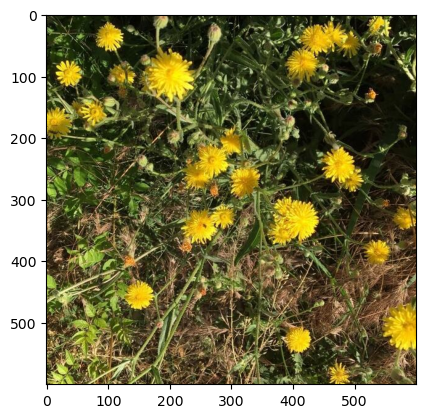

In [66]:
# itemize image and lebel, and display image
image, label = eda_data[17]       # image is in Pytorch tensor format (C, H, W)
print(f"Image type: {type(image)}, Label: {label}")

image_np = image.permute(1, 2, 0).numpy()  # need to convert the Pytorch tensor to a NumPy array
                                           # and transpose it to the (H, W, C) format
plt.imshow(image_np);
#plt.imshow(image)   # can plot directly if image has not been converted to Pytorch tensor


In [67]:
# Create an index-to-name mapping: a reverse mapping from index/label to class name
idx_to_class_mapping = {idx: class_name for class_name, idx in eda_data.class_to_idx.items()}
print(f"Index to class mapping: {idx_to_class_mapping}")

print(f"Image type: {type(image)}, Label/index: {label}, Class/name: {idx_to_class_mapping[label]}")


Index to class mapping: {0: '1355869', 1: '1355870', 2: '1355885', 3: '1355886', 4: '1355898', 5: '1355899'}
Image type: <class 'torch.Tensor'>, Label/index: 1, Class/name: 1355870


In [79]:
# Using DataLoader: for batching and shuffling data.
eda_loader = DataLoader(eda_data, batch_size=2, shuffle=True)

images, labels = next(iter(eda_loader))   # get the first batch
print(f"Batch 1 images shape: {images.shape}")
print(f"Batch 1 labels: {labels}")
print(f"Batch 1 class/folder names: {[idx_to_class_mapping[label] for label in labels.tolist()]}")


Batch 1 images shape: torch.Size([2, 3, 600, 600])
Batch 1 labels: tensor([0, 5])
Batch 1 class/folder names: ['1355869', '1355899']


In [ ]:
#==============================================
# Baseline 1: ResNet50 multi-label classifier
#==============================================
'''
– Use ImageNet pretrained ResNet50, freeze most layers initially, train a multi-label head on single-plant
  images (with multi-label loss BCEWithLogits).
  
– Apply this model to downscaled quadrats (224 x 224 pixels) by running it on the entire quadrat
  image and thresholding per class.
  
– Report macro-F1 and macro-precision / macro-recall per transect. This is the “no tiling, no ViT” baseline.

'''


In [3]:
from loading import data_loader   # get our own dataloader to preprocess input images for ResNet50
from resnet50 import resnet50_multilabel   # get pretrained ResNet50 and training functions

In [4]:
# Create an instance of the SinglePlantDataLoader

RESIZE_SIZE = 225
IMG_SIZE = 224 
BATCH_SIZE = 32
NUM_WORKERS = 4   # Use all available CPU cores for loading os.cpu_count()
# NUM_CLASSES = 7806   # As per the challenge overview, confirm this by self.classes

data_splitter = data_loader.SinglePlantDataLoader(
                                    data_dir=training_data_path,
                                    resize_size=RESIZE_SIZE,
                                    img_size=IMG_SIZE,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    train_split=0.8, val_split=0.2, test_split=0.0
                                    )

# Get the dataloaders
train_loader, val_loader, test_loader = data_splitter.get_dataloaders()

print("\n--- Dataloader Pipelines Created ---")

Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/images_max_side_800

Splitting dataset

Found 1408033 total images belonging to 7806 classes.

--- Dataloader Pipelines Created ---


In [5]:
# Create an index-to-name mapping for the full training data
idx_to_class_mapdict = {idx: class_name for class_name, idx in data_splitter.class_to_idx.items()}

# Double-check full training data size
len(data_splitter.class_to_idx), len(idx_to_class_mapdict)

(7806, 7806)

In [14]:
# Save the mappings for model inference

with open('cls_to_idx_mapdict.json', 'w') as f:
    json.dump(data_splitter.class_to_idx, f, indent=4) # indent for pretty printing

with open('idx_to_cls_mapdict.json', 'w') as g:
    json.dump(idx_to_class_mapdict, g, indent=4) # indent for pretty printing

print(f"Mapping Dictionaries saved using json.")

# To load the dictionary back:
# with open(filename, 'r') as f:
#     loaded_dictionary = json.load(f)
# print(f"Loaded dictionary: {loaded_dictionary}")

Mapping Dictionaries saved using json.


In [6]:
# Data structure of the first batch
images, labels = next(iter(train_loader))   # get the first batch
print(f"Batch images shape: {images.shape}")
print(f"Batch labels: {labels}")
print(f"Batch class/folder names: {[idx_to_class_mapdict[label] for label in labels.tolist()]}")

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([3962, 4515,  866, 2678, 2697, 6971, 1960, 6510, 1962, 1176, 2698,  130,
        5077,   22, 1686, 2692,  772, 3091, 1241, 1250, 6427,  339, 4935, 2382,
        2042,   98, 2838, 5547, 1229,  656, 5762, 1241])
Batch class/folder names: ['1393564', '1395646', '1358592', '1364059', '1364093', '1737510', '1361569', '1646254', '1361572', '1359518', '1364100', '1356201', '1397378', '1355914', '1360814', '1364079', '1358295', '1390760', '1359658', '1359675', '1622914', '1356772', '1397042', '1363264', '1361759', '1356106', '1389228', '1409132', '1359625', '1357821', '1451884', '1359658']


In [7]:
# Check the multi-hot encoding function works
multi_hots = resnet50_multilabel.label_to_multihot(labels, num_classes=7806)
multi_hots.shape

torch.Size([32, 7806])

In [6]:
# Initialize configuations for training a multi-label head

NUM_CLASS = 7806
NUM_EPOCH = 30
LR = 0.001
DEVICE = resnet50_multilabel.device
print(f'Using device: {DEVICE}')


Using device: cuda


In [7]:
# Train a Multilabel Classification Head on ResNet50 with PlantCLEF Training Data
print("\n" + "="*60)
print("Transfer Learning - Train a Multilabel Classification Head on ResNet50 with PlantCLEF Training Data")
print("="*60)

# try:
print("\nTraining ResNet50 ...")

pretrained_resnet = resnet50_multilabel.get_resnet50_pretrained(num_classes=NUM_CLASS)
num_params, trainable_params = resnet50_multilabel.count_parameters(pretrained_resnet)
model_size = resnet50_multilabel.get_model_size_mb(pretrained_resnet)
print(f"Total parameters: {num_params:,d}")
print(f"Trainable parameters: {trainable_params:,d}")
print(f"Model size: {model_size:.2f} MB")

train_history = resnet50_multilabel.train_model(pretrained_resnet, 
                               train_loader, 
                               val_loader,
                               num_classes=NUM_CLASS,
                               num_epochs=NUM_EPOCH, 
                               lr=LR,
                               device=DEVICE)

results_df = pd.DataFrame(train_history)
results_df.to_csv(f'./train_history.csv', index=False)
print(f"\nTraining {NUM_EPOCH} epochs finished! Training history saved to 'train_history.csv'")
    
# except Exception as e:
    # print(f"Error in Transfer Learning: {e}")
    # train_history = {}



Transfer Learning - Train a Multilabel Classification Head on ResNet50 with PlantCLEF Training Data

Training ResNet50 ...
Total parameters: 39,502,526
Trainable parameters: 15,994,494
Model size: 150.89 MB
currentpath /sfs/weka/scratch/hl9h

Epoch 1/30
------------------------------


Evaluating: 100%|██████████| 8801/8801 [09:47<00:00, 14.98it/s]


Train Loss: 0.0014, Train Acc: 8.18%
Val Loss: 0.0010, Val Acc: 14.91%

Best model parameters saved at epoch 1!

Epoch 2/30
------------------------------


Training:  59%|█████▉    | 20763/35201 [28:38<35:55,  6.70it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training:  69%|██████▉   | 24351/35201 [34:56<15:34, 11.61it/s]


KeyboardInterrupt: 

In [1]:
# Try fine tuning
!python resnet50_multilabel_fine_tune.py 


Loading data from: /sfs/weka/scratch/hl9h/PlantCLEF2025_data/images_max_side_800

Splitting dataset

Found 1408033 total images belonging to 7806 classes.

--- Dataloader Pipelines Created ---
Using device: cuda

Transfer Learning - Train a Multilabel Classification Head on ResNet50 with PlantCLEF Training Data

Training ResNet50 ...
Total parameters: 39,502,526
Trainable parameters: 38,057,598
Model size: 150.89 MB
currentpath /sfs/weka/scratch/hl9h

Epoch 1/20
------------------------------
Train Loss: 0.0005, Train Acc: 41.97%
Val Loss: 0.0017, Val Acc: 41.28%

Best model parameters saved at epoch 1!

Epoch 2/20
------------------------------
^C
Traceback (most recent call last):
  File "/sfs/weka/scratch/hl9h/resnet50_multilabel_fine_tune.py", line 76, in <module>
    multilabel_finetune_history = resnet50_multilabel.train_model(resnet_multilabel_model, 
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sfs/weka/scratch/hl9h/resnet5